<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/ISOTIPO-Color.jpg" title="Title text" width="20%" />

<hr style="height:2px;border:none"/>
<H1 align='center'> Pregunta de Investigación </H1>
<H5 align='center'> El uso de funciones de pérdida robustas, como la función de Huber, permite mejorar el desempeño de una red en problemas de regresión donde la salida presenta outliers. </H5>

<H3> INF-395 Redes Neuronales y Deep Learning </H3>
<H3> Autores: Francisco Andrades | Lucas Díaz</H3>

Lenguaje: Python

Temas:

    - Arquitectura de Redes Neuronales *Feed-Forward*
    - Entrenamiento de Redes Neuronales. 
    - Parte Básica de Redes Convolucionales. 
    - Problemas Especiales.
    
Videos Explicativos: 

    - https://youtu.be/DbpbfwR61Ws
    
    - https://youtu.be/WL5InIBNLos

<hr style="height:2px;border:none"/>

In [43]:
# Librerías
!pip install scipy==1.6

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import scipy
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import optimizers
# LOSSES
from tensorflow.keras.losses import Huber
from tensorflow.keras.losses import mean_squared_error as mse_loss
from tensorflow.keras.losses import mean_absolute_error as mae_loss
from tensorflow.keras.losses import LogCosh

from tensorflow.keras.callbacks import EarlyStopping

#P2
from tensorflow.keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [44]:
path = ''

<center><h1> Pregunta de Investigación </h1></center>

\
**Hipótesis:** El uso de funciones de pérdida robustas, como la función de Huber, **permite** mejorar el desempeño de una red en problemas de regresión donde la salida presenta outliers.


**Objetivo:**  Demostrar la hipótesis.

**Propuesta:** Se demostrará la hipótesis evidenciando al menos **1** caso donde la función de Huber mejora el desempeño de una arquitectura frente a la función de pérdida *Mean Squared Error*. Posteriormente se extenderá la demostración a otras funciones de pérdida robustas.

**Metodología** 
1. Se harán experimentos en 2 datasets sintéticos y 2 reales, utilizando una arquitectura feed-forward **fija para cada dataset**.
2. Se entrenará la arquitectura de forma independiente para cada función de pérdida y se evaluará utilizando como métricas MAE y MSE.
3. Se ejecutarán N iteraciones del paso 2 y se obtendrá una distribución de resultados pertinente a cada función de pérdida.
4. Mediante Hipótesis Testing, se responderá a la siguiente pregunta para cada métrica: ¿Se puede afirmar, con determinada confianza, que la media de la distribución generada por Huber es estrictamente menor a la media de la distribución generada por MSE?
5. Si la respuesta es positiva para ambas métricas en al menos **1** caso, se entenderá por demostrada la hipótesis. 

**Esqueleto**
1. Recordatorio MSE, MAE, HUBER.
    - ¿Por qué escogemos MSE como la función de pérdida a comparar?
    - ¿Por qué consideramos que la hipótesis debiese ser cierta?
2. Descripción de los datasets.
    -  ¿Por qué los escogimos?
3. Evaluación de los modelos.
    - ¿Por qué utilizar MAE y MSE como métricas?
4. Experimentos.
    - Generación de las distribuciones.
    - Hipótesis Testing.
5. Extensión a otras funciones de pérdida robustas.
    - LogCosh()

****
<center><h3> 1. Recordatorio MSE, MAE Y HUBER </h3></center>


#### MSE

- Media de los errores al cuadrado (Norma L2)
- Sensible a outliers

$$MSE = \frac{\sum_{i=1}^n(y_i-y_i^p)^2} {n}$$

<img src="assets/mse.png" title="Title text" />

#### MAE

- Media del valor absoluto de los errores (Norma L1)
- Diferenciable por trazos.

$$MAE = \frac{\sum_{i=1}^n|y_i-y_i^p|} {n}$$
<img src="assets/mae.png" title="Title text" />

#### Huber

- Combina MSE con MAE.
- MAE, pero se convierte en MSE para errores pequeños.
- Robustez frente a outliers (MAE), pero diferenciable en 0 (MSE).

En 1964, Peter Huber, en su *paper Robust estimation of a location parameter*, define la función (con $k(\epsilon)$):

\begin{equation*}
    \rho(y - f(x)) = 
            \begin{cases}
            \frac{1}{2}(y - f(x))^2 &      \text{ para } \quad |y - f(x)| < \delta \\ 
            \delta|y - f(x)| - \frac{1}{2}\delta^2 &  \text{ para } \quad |y - f(x)| \geq \delta
            \end{cases}
\end{equation*}

<img src="assets/huber.png" title="Title text" />

Por conveniencia, se puede reescribir la función de Huber con parámetros utilizados en este trabajo, así:

\begin{align*}
    t &= y - f(x)\\
    k &= \delta
\end{align*}


\begin{equation*}
    \rho(y - f(x)) = 
            \begin{cases}
            \frac{1}{2}(y - f(x))^2 &      \text{ para } \quad |y - f(x)| < \delta \\ 
            \delta|y - f(x)| - \frac{1}{2}\delta^2 &  \text{ para } \quad |y - f(x)| \geq \delta
            \end{cases}
\end{equation*}

donde: 

\begin{align*}
y&: \text{ valor real.}\\
f(x)&: \text{ predicción del modelo.}
\end{align*}

- Sintonización parámetro $\delta$ en Huber($\delta$):

Se puede interpretar $\delta$ como el valor en donde el modelo comienza a considerar "grande" la diferencia entre el valor real y la predicción.

****

<center><h3> 2. Descripción de los datasets </h3></center>




Se trabajarán con dos datasets sintéticos y dos datasets reales. 

* **Dataset sintético 1**: No contiene outliers.

* **Dataset sintético 2**: Contiene outliers.

* **Dataset real Boston housing price**: Contiene outliers moderados.

* **Dataset real Challenge**: Contiene outliers extremos.

Todos los datasets se preprocesarán de la siguiente forma:

In [45]:
from sklearn.compose import make_column_selector as selector

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_include="number")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
])    

In [46]:
def procesar_data(X, y):
    x_train, x_test, y_train, y_test = [pd.DataFrame(elem) for elem in train_test_split(X, 
                                                                                        y, 
                                                                                        shuffle=True, 
                                                                                        random_state=1)]
    
    x_train, x_test = preprocessor.fit_transform(x_train), preprocessor.transform(x_test)
    y_train, y_test = preprocessor.fit_transform(y_train), preprocessor.transform(y_test)
    
    return x_train, x_test, y_train, y_test

## Datasets sintéticos

La construcción de datasets sintéticos busca mostrar de forma más evidente la ventaja de utilizar -en problemas de regresión- un modelo con una loss function robusta a *outliers*, frente a una que no.

En este caso, los modelos a utilizar son:

* Regresión lineal utilizando **MSE** como *loss function*.

* Regresión lineal utilizando la función de **Huber** como *loss function*.

Para la generación de los datasets, se utiliza la función ```gendata2(n_samples, n_outliers)```. En dicha función, ```n_samples``` corresponde a la cantidad de datos totales que se utilizarán, mientras ```n_outliers``` es una fracción del total de datos, correspondiente a la cantidad de outliers.

A continuación, se generarán los datasets sintéticos a utilizar:

* A la izquierda, el dataset sintético **sin outliers**, donde los modelos obtendrán un resultado similar.
* A la derecha, en cambio, el dataset sintético **con outliers**, donde el modelo con una *loss function* robusta se desempeñará mejor.

In [47]:
def gendata(n_samples=1000, n_outliers=50):
    X = np.linspace(0, 100, n_samples)

    y = np.linspace(0, 100, n_samples) + np.random.normal(0, 5, n_samples)
    
    arreglo_pos = np.random.randint(0, n_samples, n_outliers)
    
    y[arreglo_pos] = y[arreglo_pos] + (np.random.choice((-1,1),size=n_outliers)
                                       *np.random.randint(50, 210, n_outliers))    
    
    return X, y

# Datasets sintéticos
X, y = gendata(400, 0)
X_outliers, y_outliers = gendata(400, 10)

# Preprocesar datasets sintéticos

    #sin outliers
x_train_sint, x_test_sint, y_train_sint, y_test_sint = procesar_data(X, y)

    #con outliers
x_train_sintout, x_test_sintout, y_train_sintout, y_test_sintout = procesar_data(X_outliers, y_outliers)

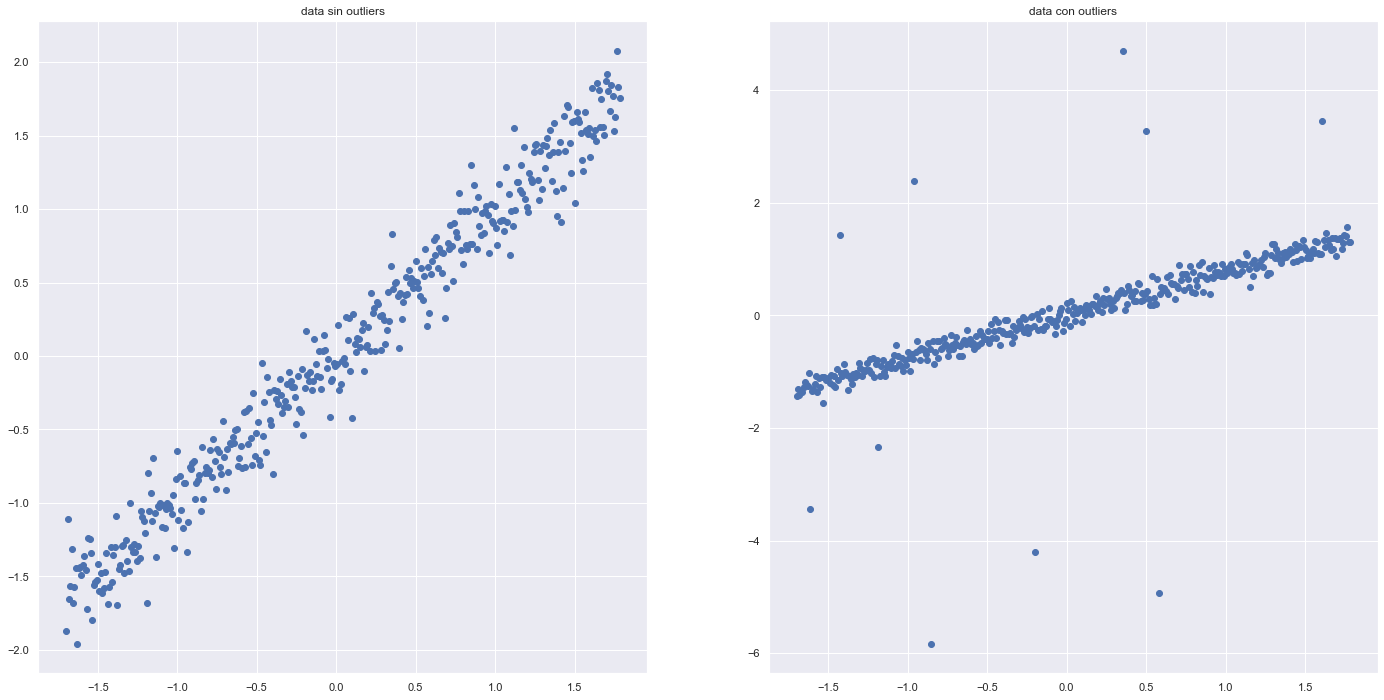

In [48]:
#PLOTEANDO
fig, ax = plt.subplots(1, 2, figsize=(24,12))

ax[0].scatter(np.concatenate((x_train_sint, 
                              x_test_sint)), 
              np.concatenate((y_train_sint,
                              y_test_sint)))
ax[0].set_title('data sin outliers')


ax[1].scatter(np.concatenate((x_train_sintout, 
                              x_test_sintout)), 
              np.concatenate((y_train_sintout,
                              y_test_sintout)))
ax[1].set_title('data con outliers')
   
plt.show()

Al comparar ambos gráficos, es notoria la presencia de outliers en el que está ubicado a la derecha. Dicha "exageración" en los datos que son atípicos, evidenciará de mejor manera el desempeño de ambos métodos.


A continuación, se utilizará la herramienta para diagramas de caja ```pyplot.boxplot()```, para interpretar la distribución de los datos a través de sus cuartiles, además de poder representar los valores atípicos.

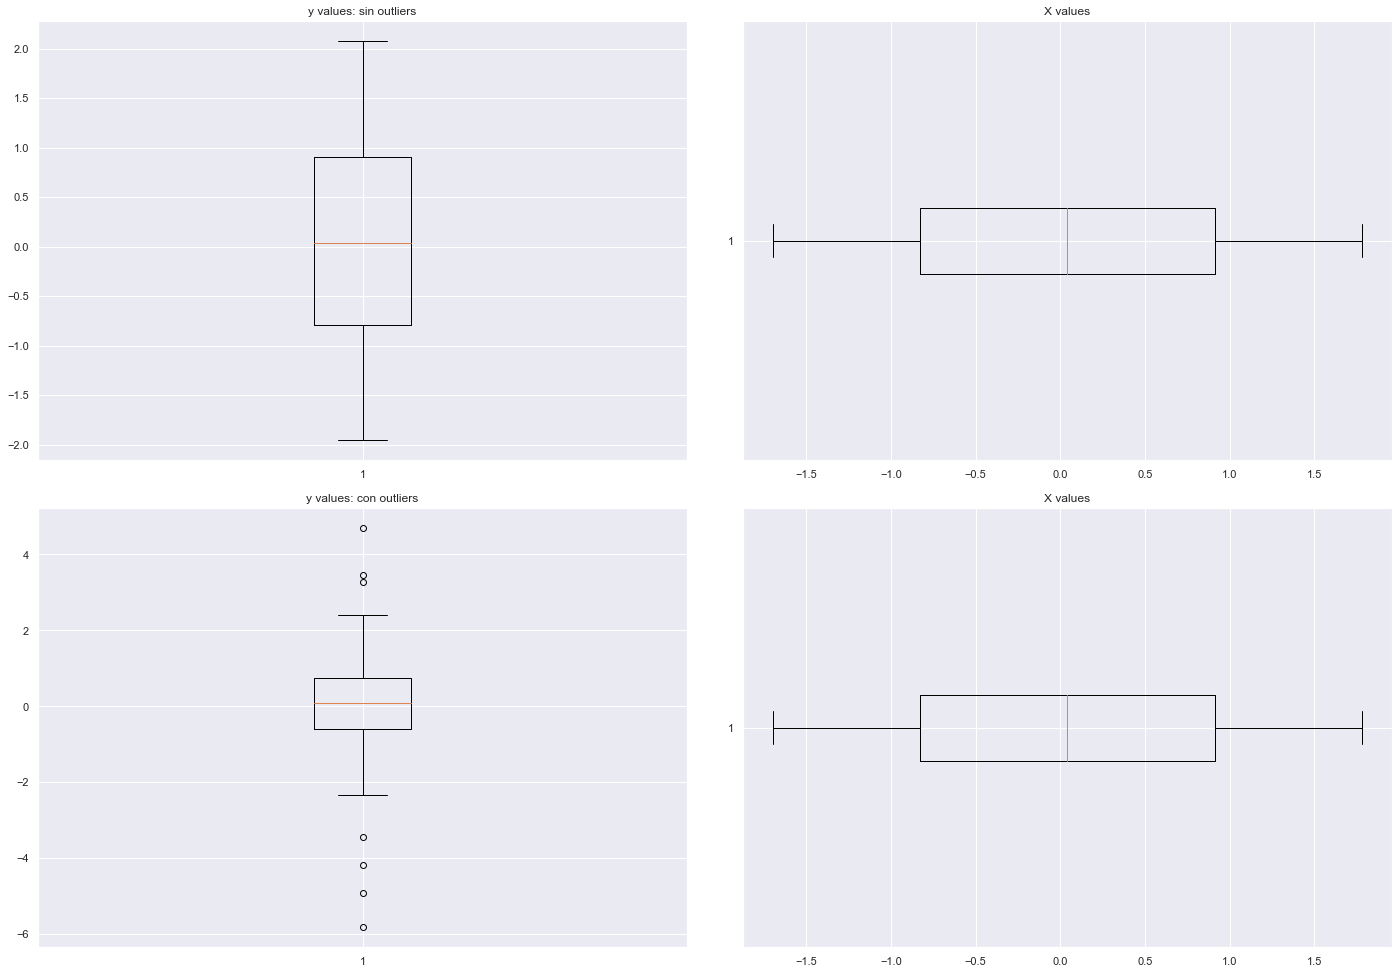

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(20,14))

ax[0, 0].boxplot(np.concatenate((y_train_sint, y_test_sint)))
ax[0, 0].set_title('y values: sin outliers')
ax[0, 1].boxplot(np.concatenate((x_train_sint, x_test_sint)), vert=False)
ax[0, 1].set_title('X values')

fig.tight_layout(pad=2.0)#just to separate

ax[1, 0].boxplot(np.concatenate((y_train_sintout, y_test_sintout)))
ax[1, 0].set_title('y values: con outliers')
ax[1, 1].boxplot(np.concatenate((x_train_sintout, x_test_sintout)), vert=False)
ax[1, 1].set_title('X values')

plt.show()

Lo anterior, permite vislumbrar que los valores atípicos del segundo dataset están, en efecto, significativamente distantes con respecto al resto de datos. Por contraparte, con esta herramienta, el primer dataset tampoco presenta valores atípicos.

Finalmente, cabe destacar la organización de los valores de *X*, que a simple vista se muestran distribuidos uniformemente.

# Datasets reales

Los datasets reales a utilizar corresponden a:

* ```boston_housing```: importado desde ```tensorflow.keras.datasets```, dataset que tiene outliers moderados.
* **metadata_casas_train.csv**: utilizado en la segunda parte de la Tarea, dataset con valores atípicos en la columna **'precio'**, con outliers extremos.

En el caso del dataset Boston, se utilizará una una red neuronal de 3 capas densas (2 ocultas + 1 de salida).

Para el dataset del Challenge, se utilizará una red neuronal con 2 capas densas(1 oculta + 1 de salida).

Funciones de pérdida a utilizar:
* MSE loss function.
* Huber loss function.

Lo anterior, pretende buscar si es que la naturaleza de los valores atípicos genera algún cambio a la hora de resolver un problema con determinadas *loss functions*.

In [50]:
from tensorflow.keras.datasets import boston_housing

#BOSTON
(x_train, y_boston), (x_test, y_test) = boston_housing.load_data()

X = np.concatenate((x_train, x_test))
y = np.concatenate((y_boston, y_test))

X_train_boston, X_test_boston, y_train_boston, y_test_boston = procesar_data(X, y)

#CASAS CHALLENGE
df_train = pd.read_csv(path+'metadata_casas_train.csv',index_col=0)

df_houses = pd.read_csv(path+'metadata_casas_train.csv',index_col=0)
df_houses.zipcode = df_houses.zipcode.astype('category')
y_houses = pd.DataFrame(np.array(df_houses.pop('precio')).reshape(-1,1))


X_train_challenge, X_test_challenge, y_train_challenge, y_test_challenge = procesar_data(df_houses, y_houses)


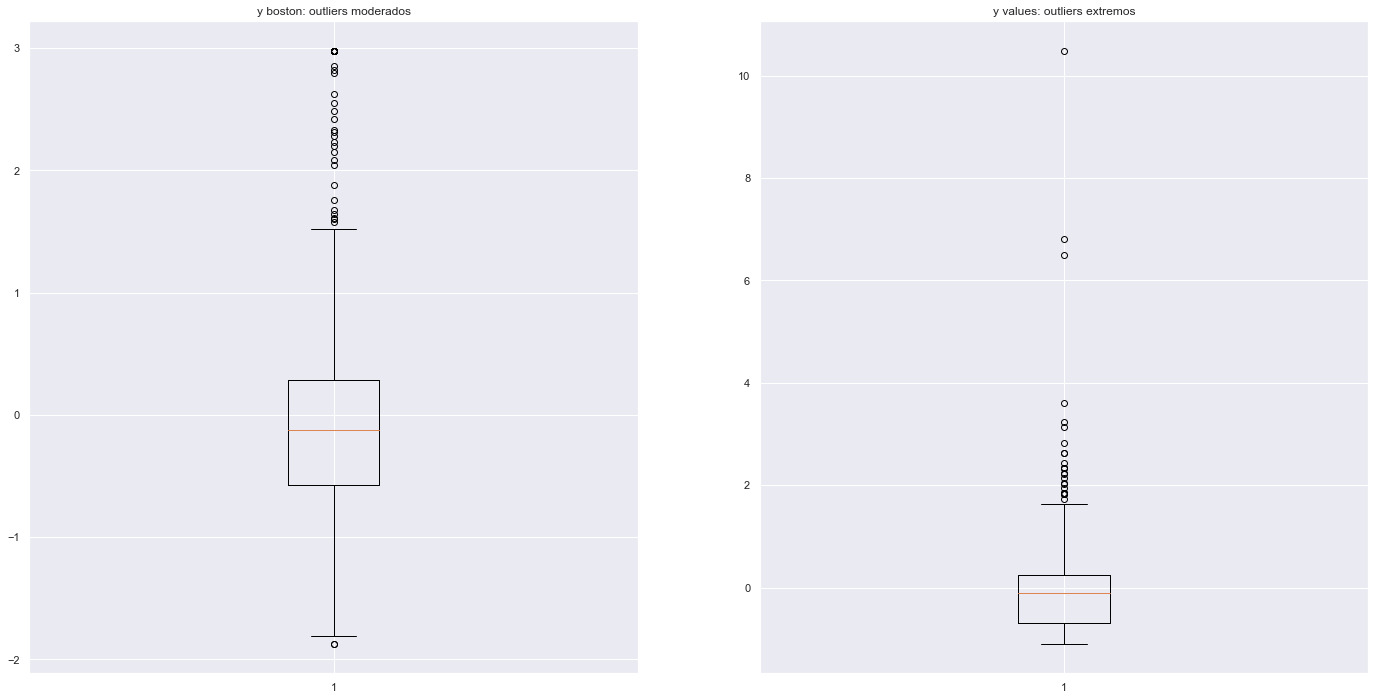

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(24,12))

ax[0].boxplot(np.concatenate((y_train_boston, y_test_boston)))
ax[0].set_title('y boston: outliers moderados')

ax[1].boxplot(np.concatenate((y_train_challenge, y_test_challenge)))
ax[1].set_title('y values: outliers extremos')

plt.show()


****
<center><h3> 3. Evaluación de los modelos </h3></center>

Para evaluar los modelos se escogieron las métricas MAE y MSE.

¿Es válido evaluar los modelos utilizando estas métricas?


Se presentará un pequeño experimento para demostrar que las métricas son, en efecto, válidas y que la función de pérdida con que se entrena el modelo **no asegura un mejor desempeño cuando coincide con alguna de las métricas**.


In [52]:
def pequeño_experimento(n_samples=1000, n_outliers=50):
    X = np.linspace(0, 100, n_samples)
    y = np.linspace(0, 100, n_samples) + np.random.normal(0, 5, n_samples)
    
    np.random.seed(5)
    arreglo_pos = np.random.randint(0, n_samples, n_outliers)
    
    y[arreglo_pos] = y[arreglo_pos] + np.random.randint(50, 210, n_outliers)  
    return X, y

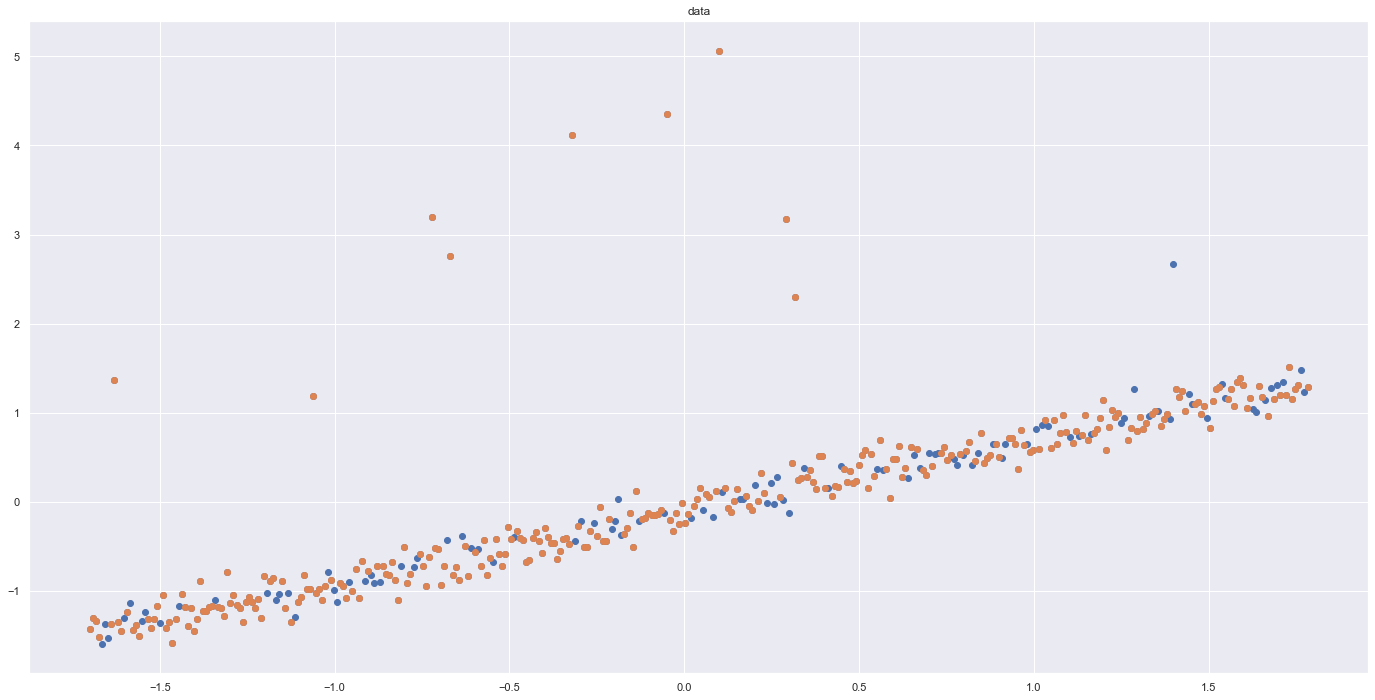

In [53]:
X_p, y_p = pequeño_experimento(400, 10)
x_train_sint_p, x_test_sint_p, y_train_sint_p, y_test_sint_p = procesar_data(X_p, y_p)

#PLOTEANDO
fig = plt.figure(figsize=(24,12))

plt.scatter(np.concatenate((x_train_sint_p, 
                            x_test_sint_p)), 
            np.concatenate((y_train_sint_p,
                            y_test_sint_p)))

plt.scatter(x_train_sint_p, 
            y_train_sint_p)
plt.title('data')
plt.show()

In [54]:
def linearmodels(n_features, loss):
    inputs = keras.Input(shape=(n_features, ), name='input_data')
    outputs = layers.Dense(1, name='output')(inputs)
    model = keras.Model(inputs=inputs, outputs = outputs, name='modelo')
    model.compile(loss = loss, 
                  optimizer=optimizers.Adam(lr=0.01), 
                  metrics=['mean_absolute_error','mean_squared_error'],
                 )
    return model

In [55]:
modelo_huber = linearmodels(x_train_sint_p.shape[1],mae_loss)
modelo_mse = linearmodels(x_train_sint_p.shape[1],mse_loss)

In [56]:
history = modelo_huber.fit(x_train_sint_p,y_train_sint_p,epochs=50,
                           verbose=0,)
history2 = modelo_mse.fit(x_train_sint_p,y_train_sint_p,epochs=50,
                          verbose=0,)

preds_huber = modelo_huber.predict(x_test_sint_p)
preds_mse = modelo_mse.predict(x_test_sint_p)

print('MSE con loss MAE: ', mse(preds_huber,y_test_sint_p))
print('MSE con loss MSE: ', mse(preds_mse,y_test_sint_p))

print('\nMAE con loss MAE: ', mae(preds_huber,y_test_sint_p))
print('MAE con loss MSE: ', mae(preds_mse,y_test_sint_p))

hide_toggle()

MSE con loss MAE:  0.041196428311516174
MSE con loss MSE:  0.04725872877278875

MAE con loss MAE:  0.11049072496476306
MAE con loss MSE:  0.13411814509041042


****
<center><h3> 4. Experimentos </h3></center>

#### Pipeline del Experimento

In [57]:
def one_iteration(loss, model_func, verbose, *data_args):
    
    x_train,y_train,x_test,y_test = data_args
    
    n_features = x_train.shape[1]
    model = model_func(n_features, loss)
    history = model.fit(
        x = x_train,
        y = y_train,
        batch_size=32,
        epochs=100,
        verbose=0,
    )
    test_results = model.evaluate(x_test, y_test, verbose=0)
    if not(verbose):
        return test_results[1], test_results[2]
    

#### Pipeline del Experimento

In [58]:
def experiment(loss, model_func, plot, *data_args):
    x_train,y_train,x_test,y_test = data_args
    maes = np.array([one_iteration(loss, model_func, False, x_train, y_train, x_test, y_test) for i in range(100)])
    if plot:
        fig = plt.figure(figsize=(20, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.set_title('MAE')
        ax2.set_title('MSE')
        ax1.hist(maes[:,0])
        ax2.hist(maes[:,1])
        plt.show()
    return maes

#### Sintetic Dataset

In [59]:
def linearmodels(n_features, loss):
    inputs = keras.Input(shape=(n_features, ), name='input data')
    outputs = layers.Dense(1, name='output')(inputs)
    model = keras.Model(inputs=inputs, outputs = outputs, name='modelo')
    model.compile(loss = loss, 
                  optimizer=optimizers.Adam(lr=0.01), 
                  metrics=['mean_absolute_error','mean_squared_error'],
                 )
    return model

> #### Sin outliers

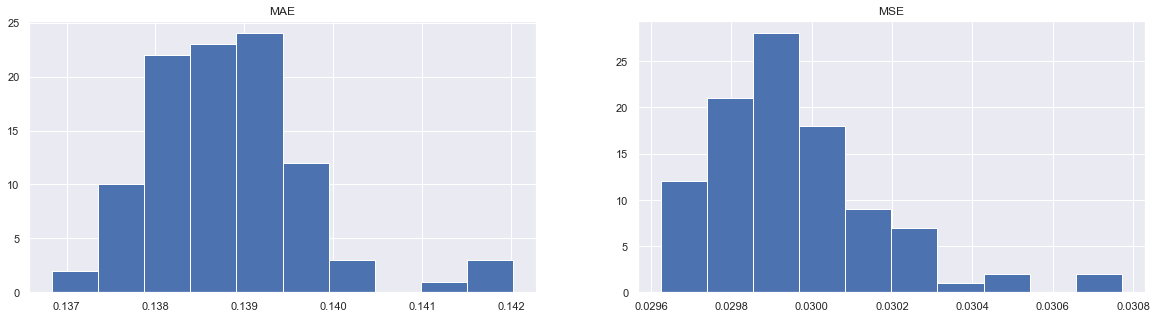

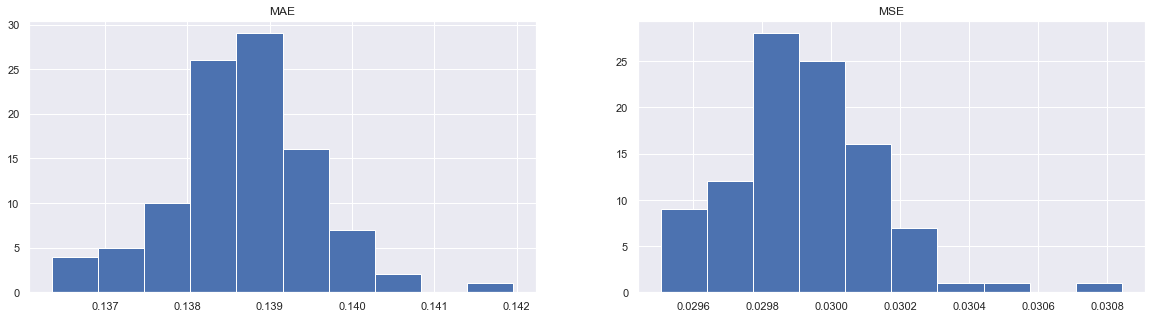

In [60]:
sintetic_huber = experiment(Huber(1),
                            linearmodels,
                            True,
                            x_train_sint,
                            y_train_sint,
                            x_test_sint,
                            y_test_sint
                           )
sintetic_mse = experiment(mse_loss,
                          linearmodels,
                          True,
                          x_train_sint,
                          y_train_sint,
                          x_test_sint,
                          y_test_sint
                         )


In [61]:
# H0: mean_mse <= mean_huber
# H1: mean_mse > mean_huber 
print("Resultado para MAE: ", stats.ttest_ind(sintetic_mse[:, 0], sintetic_huber[:, 0], alternative='greater'))
print("Resultado para MSE: ", stats.ttest_ind(sintetic_mse[:, 1], sintetic_huber[:, 1], alternative='greater'))

Resultado para MAE:  Ttest_indResult(statistic=-0.8737023794784703, pvalue=0.8083306087635856)
Resultado para MSE:  Ttest_indResult(statistic=-1.1105159126041166, pvalue=0.8659382187911061)


> #### Con outliers

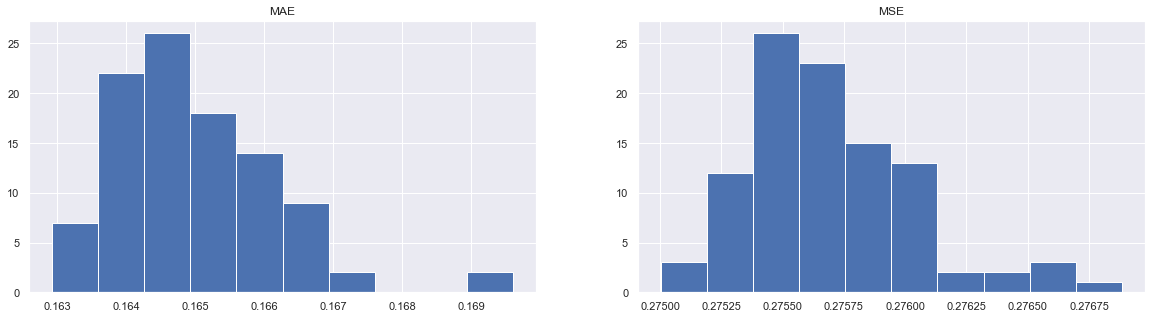

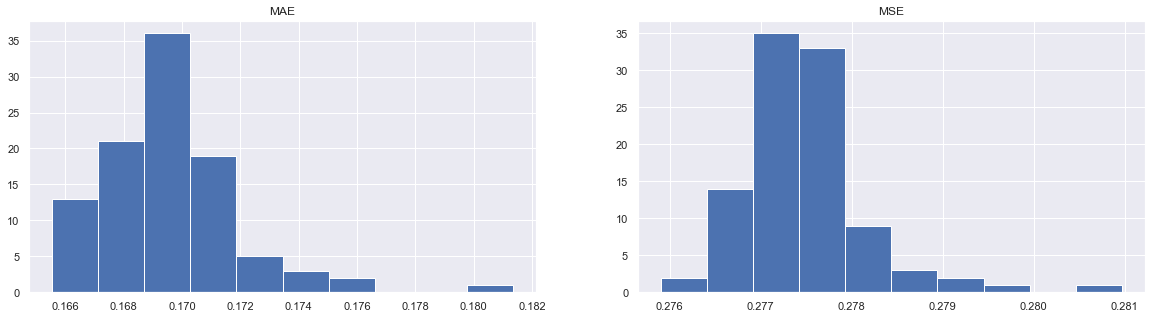

In [62]:
sintetic_outliers_huber = experiment(Huber(1), linearmodels, True,
                                     x_train_sintout, y_train_sintout,
                                     x_test_sintout, y_test_sintout)

sintetic_outliers_mse = experiment(mse_loss, linearmodels, True,
                                   x_train_sintout, y_train_sintout,
                                   x_test_sintout, y_test_sintout)


In [63]:
print("Resultados MAE: ", stats.ttest_ind(sintetic_outliers_mse[:, 0], sintetic_outliers_huber[:, 0], alternative='greater'))
print("Resultados MSE: ", stats.ttest_ind(sintetic_outliers_mse[:, 1], sintetic_outliers_huber[:, 1], alternative='greater'))

Resultados MAE:  Ttest_indResult(statistic=17.488092543084342, pvalue=2.5262852393005206e-42)
Resultados MSE:  Ttest_indResult(statistic=22.99484427063339, pvalue=4.095052397409369e-58)


#### Boston Housing Dataset

In [64]:
def boston_model(n_features,loss):
    inputs = keras.Input(shape=(n_features, ), name='input_boston')
    x = layers.Dense(16, activation='relu')(inputs)
    x = layers.Dense(8, activation='relu')(x)
    outputs = layers.Dense(1, name='Output')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='Modelo_boston')
    model.compile(loss=loss,optimizer='adam',metrics=['mean_absolute_error','mean_squared_error'])
    return model

#### Boston Housing Dataset

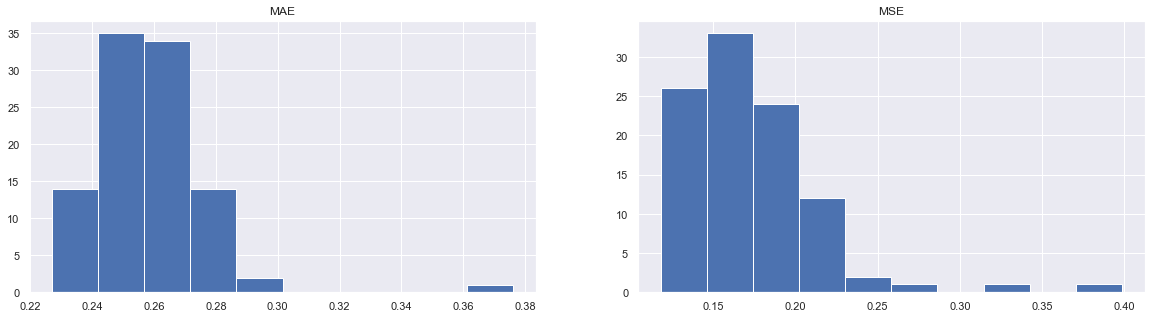

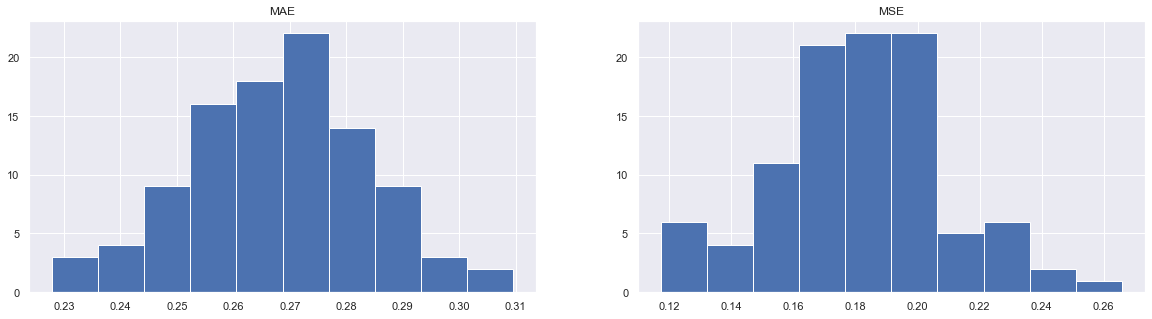

In [65]:
boston_huber = experiment(Huber(0.1), boston_model, True,
                          X_train_boston, y_train_boston,
                          X_test_boston, y_test_boston)
boston_mse = experiment(mse_loss, boston_model, True,
                        X_train_boston, y_train_boston,
                        X_test_boston, y_test_boston)


In [66]:
print("Resultados MAE: ", stats.ttest_ind(boston_mse[:, 0], boston_huber[:, 0], alternative='greater'))
print("Resultados MSE: ", stats.ttest_ind(boston_mse[:, 1], boston_huber[:, 1], alternative='greater'))

Resultados MAE:  Ttest_indResult(statistic=3.944972662648769, pvalue=5.5377310138874965e-05)
Resultados MSE:  Ttest_indResult(statistic=1.7419278573077739, pvalue=0.041536981277773985)


#### Challenge Dataset

In [67]:
def challenge_model(n_features,loss):
    inputs = keras.Input(shape=(n_features, ), name='input_challenge')
    x = layers.Dense(4, activation='relu')(inputs)
    outputs = layers.Dense(1, name='Output')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='Modelo_challenge')
    model.compile(loss=loss,optimizer='adam',metrics=['mean_absolute_error','mean_squared_error'])
    return model

#### Challenge Dataset

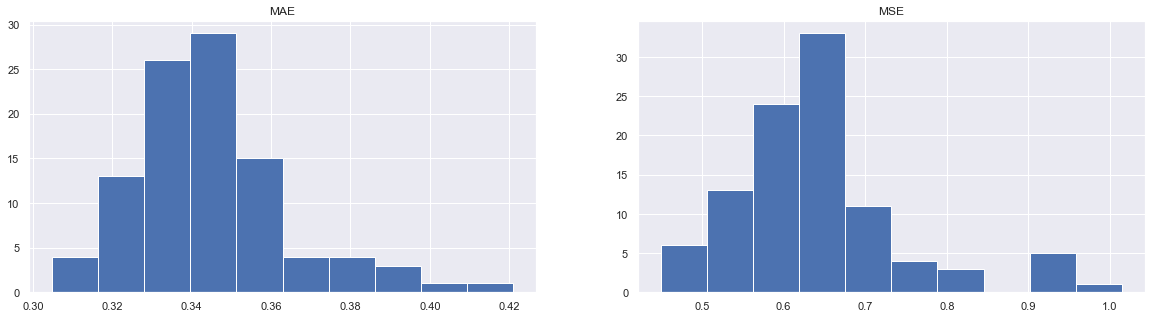

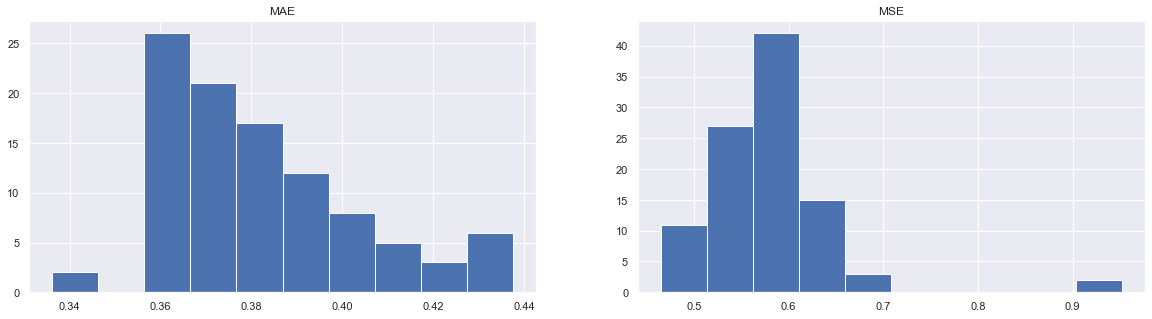

In [68]:
challenge_huber = experiment(Huber(0.1), challenge_model, True,
                             X_train_challenge, y_train_challenge,
                             X_test_challenge, y_test_challenge)

challenge_mse = experiment(mse_loss, challenge_model, True,
                             X_train_challenge, y_train_challenge,
                             X_test_challenge, y_test_challenge)


In [99]:
print("Resultados MAE: ", stats.ttest_ind(challenge_mse[:, 0], challenge_huber[:, 0], alternative='greater'))
print("Resultados MSE: ", stats.ttest_ind(challenge_mse[:, 1], challenge_huber[:, 1], alternative='greater'))

Resultados MAE:  Ttest_indResult(statistic=14.16762999543144, pvalue=3.180405821688636e-32)
Resultados MSE:  Ttest_indResult(statistic=-4.246195086577404, pvalue=0.9999832903073754)


***
<center><h3>5. Extensión a otras <i>loss functions</i> robustas </h3></center>

#### LogCosh Loss

\begin{equation}
L(y, y^p) = \sum_{i=1}^n log(cosh(y_{i}^p - y_i))
\end{equation}

<img src="assets/logcosh.png" title="Title text" />

#### Challenge Dataset

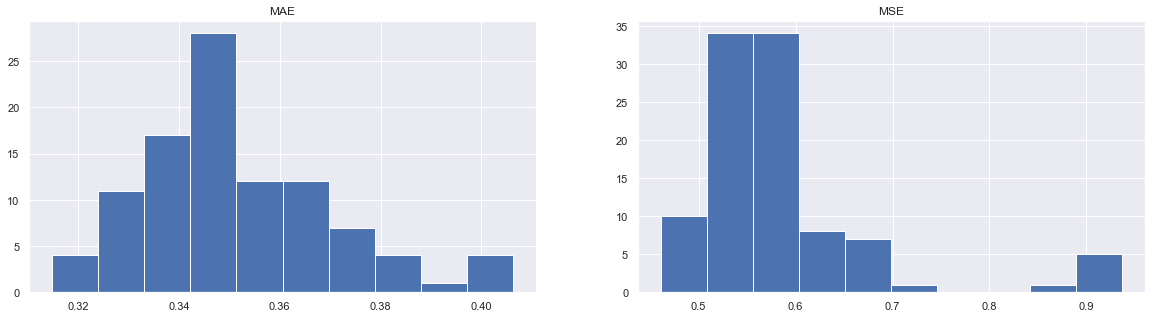

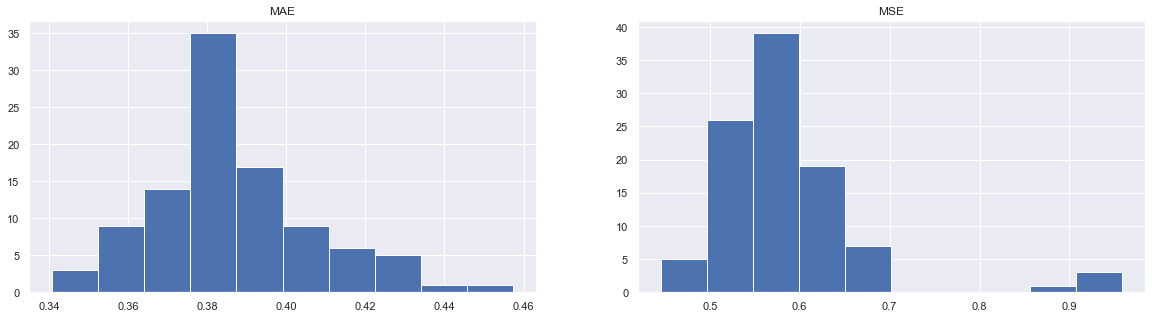

In [70]:
challenge_logcosh = experiment(LogCosh(), challenge_model, True,
                             X_train_challenge, y_train_challenge,
                             X_test_challenge, y_test_challenge)

challenge_mse = experiment(mse_loss, challenge_model, True,
                             X_train_challenge, y_train_challenge,
                             X_test_challenge, y_test_challenge)


In [71]:
print("Resultados MAE: ", stats.ttest_ind(challenge_mse[:, 0], challenge_logcosh[:, 0], alternative='greater'))
print("Resultados MSE: ", stats.ttest_ind(challenge_mse[:, 1], challenge_logcosh[:, 1], alternative='greater'))

Resultados MAE:  Ttest_indResult(statistic=12.267830600650663, pvalue=2.1055720093883013e-26)
Resultados MSE:  Ttest_indResult(statistic=0.05287432502408132, pvalue=0.4789426744847888)


# Conclusiones

* Dados los resultados experimentales, efectivamente favorece el desempeño de un modelo el ser entrenado con una función de pérdida robusta como Huber.

* Como complemento del punto anterior, también se muestra experimentalmente que otras funciones robustas -como LogCosh- mejoran el desempeño de MSE como función de pérdida.


* Como punto de mejora a esta investigación, se podría haber demostrado que utilizar una función robusta como Huber, nunca empeora el resultado que se obtiene con MSE como función de pérdida.